<a href="https://www.kaggle.com/code/aaalexlit/from-simple-cnn-to-transfer-learning-on-tpu?scriptVersionId=109252508" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aaalexlit/kaggle-notebooks/blob/main/from-simple-cnn-to-transfer-learning-on-tpu.ipynb)

> Please look up for `RUN_IN_COLAB` comments and apply the instructions when running on Google Colab environment

# How to prepare your image dataset to train on TPU

## Some TPUs background

Neural network training speed can be increased significantly using TPUs ([Tensor Processing Unit](https://en.wikipedia.org/wiki/Tensor_Processing_Unit)) - accelerators for deep learning that implement matrix multiplication on hardware and therefore ridiculously reducing computation time.

If you're interested in diving deeper into TPUs here's a [link](https://www.youtube.com/watch?v=JC84GCU7zqA) to a nice introductory video by Kaggle or [this](https://codelabs.developers.google.com/codelabs/keras-flowers-tpu#2) introduction to TPUs in text.

At the time of writing, 20 hours per week of TPUs time is available on Kaggle for free. But everything comes with a price and to be able to use the benefits of TPUs one needs to adjust their code significantly. Sometimes it requires almost complete re-write of the data pre-processing pipeline and the reason being that TPUs can read training data exclusively from GCS (Google Cloud Storage).

In [1]:
# Initial imports
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from tensorflow.keras import layers

import tensorflow_hub as hub

import pandas as pd
import os
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# RUN_IN_COLAB comment the next line
from kaggle_datasets import KaggleDatasets

import random
import math

2022-10-27 05:52:39.908175: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-10-27 05:52:39.908293: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.4.1


## Locate TPUs on the network and instanciate TPUStrategy

Also the following code will allow training on CPU if TPU is not available

In [3]:
try: # detect TPUs
    # Locate TPUs on the network
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect() # TPU detection
    # TPUStrategy contains the necessary distributed training code that will work on TPUs with their 8 compute cores
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError: # If TPU is not available
    strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU

2022-10-27 05:52:45.393281: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-10-27 05:52:45.396162: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-10-27 05:52:45.396188: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-27 05:52:45.396209: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (0cd722f07333): /proc/driver/nvidia/version does not exist
2022-10-27 05:52:45.398783: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

In [4]:
print("Number of accelerators: ", strategy.num_replicas_in_sync)

Number of accelerators:  8


### Notes on Data Loading

> ***Note that the best practice is***  
> For TPU training, organize your data in GCS in a reasonable number (10s to 100s) of reasonably large files (10s to 100s of MB). With too few files, GCS will not have enough streams to get max throughput. With too many files, time will be wasted accessing each individual file.

Unfortunately, in this case we're not the owners of the dataset.
Still, using TPU gives a significant improvement in training speed. The same training done on CPU takes from 2 minutes per epoch comparing to 1 seconds per epoch (the actual time depends on data preprocessing setting etc.) on TPU. 

If you want to convert your own image dataset to `TFRecord` file format [here](https://codelabs.developers.google.com/codelabs/keras-flowers-tpu/#4) you can find an amazing tutorial.  
Again, in this notebook we won't convert images to `TFRecord` file format, but still using TPU mindblowingly increases training speed and totally worth the effort.

# The steps that we will follow to create the TF datasets are the following:  

0. **Setting up and helper functions**
1. **Prepare stratified train validation split.** Split all available `Train` images' filepaths into two lists - training and validation - in a stratified manner. Ie so that each disease class is equally represented in both lists.
1. **One-hot encode the labels**
1. **Create training and validation `tf.data.Dataset`** (from now on I'll refer to it as just Dataset) from filepaths and labels respectively and zip them together into one  
1. **Map the filenames Dataset to get images Dataset**
1. **Optimize Datasets for training**

### Why would we use this approach?

With the current directory structure (ie all the images in one directory) we could've used `ImageDataGenerator.flow_from_dataframe` method  
But it doesn't seem to work with GCS giving and error
>  UserWarning: Found 1821 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.  

When called with a path to the local input i.e. `../input/plant-pathology-2020-fgvc7/images` it works with no issues.

And besides `ImageDataGenerator` has been deprecated and it's recommended to use `tf.keras.utils.image_dataset_from_directory` which is not convenient with all the files in one directory.


## 0. Setting up and helper functions
So, first we need to get a path to the current dataset in Google Cloud Storage

In [5]:
# RUN_IN_COLAB comment the next line and uncomment the one after next
GCS_PATH = KaggleDatasets().get_gcs_path()
# GCS_PATH = 'gs://kds-0a9d45aee2df58421126826bacd5c7a1f70af6a57258e98e446b42e4'
GCS_PATH_IMAGES = os.path.join(GCS_PATH, 'images')
GCS_PATH_IMAGES

'gs://kds-c21c9ca41b1c62ae12465f802200ef74ebe2a45995f976d3da5e693a/images'

We can check that the files are indeed there using `gsutil` to list the bucket 

In [6]:
!gsutil ls $GCS_PATH_IMAGES | tail -n 10

gs://kds-c21c9ca41b1c62ae12465f802200ef74ebe2a45995f976d3da5e693a/images/Train_990.jpg
gs://kds-c21c9ca41b1c62ae12465f802200ef74ebe2a45995f976d3da5e693a/images/Train_991.jpg
gs://kds-c21c9ca41b1c62ae12465f802200ef74ebe2a45995f976d3da5e693a/images/Train_992.jpg
gs://kds-c21c9ca41b1c62ae12465f802200ef74ebe2a45995f976d3da5e693a/images/Train_993.jpg
gs://kds-c21c9ca41b1c62ae12465f802200ef74ebe2a45995f976d3da5e693a/images/Train_994.jpg
gs://kds-c21c9ca41b1c62ae12465f802200ef74ebe2a45995f976d3da5e693a/images/Train_995.jpg
gs://kds-c21c9ca41b1c62ae12465f802200ef74ebe2a45995f976d3da5e693a/images/Train_996.jpg
gs://kds-c21c9ca41b1c62ae12465f802200ef74ebe2a45995f976d3da5e693a/images/Train_997.jpg
gs://kds-c21c9ca41b1c62ae12465f802200ef74ebe2a45995f976d3da5e693a/images/Train_998.jpg
gs://kds-c21c9ca41b1c62ae12465f802200ef74ebe2a45995f976d3da5e693a/images/Train_999.jpg


### Set up batch size, image size etc.

Using some wisdom from the Google's [Cloud TPU performance guide](https://cloud.google.com/tpu/docs/performance-guide)

* **BATCH SIZE** The ideal would be to have a batch size of 128 * `strategy.num_replicas_in_sync` but since our dataset is very small, we'll use a general rule of thumb: *In general, your batch size should be evenly divisible by 8 or 128.*
* **IMAGE SIZE** feature dimension sizes should be a multiple of 128

The latter setting is not strictly necessary cause according to the following note from the guide it's mainly talking about the inner dimensions:

> Feature dimension refers to the hidden size of a fully-connected layer or the number of output channels in a convolution. Not all layers can conform to this rule, especially the first and last layers of the network. This is fine, most models require some amount of padding.

But it shouldn't hurt either way

In [7]:
BATCH_SIZE = 8 * strategy.num_replicas_in_sync

AUTOTUNE = tf.data.AUTOTUNE

IMG_SIZE = 128*2

Read in train and test images' filenames.  
Both datasets contain 1821 jpg images

In [8]:
train_val_filenames = tf.io.gfile.glob(str(GCS_PATH_IMAGES + '/Train*'))
test_filenames = tf.io.gfile.glob(str(GCS_PATH_IMAGES + '/Test*'))

2022-10-27 05:53:07.673599: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-10-27 05:53:07.837131: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-10-27 05:53:07.934645: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-10-27 05:53:08.037918: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-10-27 05:53:08.133773: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


In [9]:
len(train_val_filenames), len(test_filenames)

(1821, 1821)

Now let's take a glance at the structure of labels

In [10]:
# RUN_IN_COLAB uncomment the next line
#!gsutil cp gs://kds-0a9d45aee2df58421126826bacd5c7a1f70af6a57258e98e446b42e4/*.csv .

In [11]:
train_df = pd.read_csv(f'{GCS_PATH}/train.csv')
test_df = pd.read_csv(f'{GCS_PATH}/test.csv')
# RUN_IN_COLAB comment the lines before and uncomment the lines after
# train_df = pd.read_csv('/content/train.csv')
# test_df = pd.read_csv('/content/test.csv')
train_df.tail()

,image_id,healthy,multiple_diseases,rust,scab
1816,Train_1816,0,0,0,1
1817,Train_1817,1,0,0,0
1818,Train_1818,1,0,0,0
1819,Train_1819,0,0,1,0
1820,Train_1820,0,0,0,1


And get a list of available labels (column names from `train.csv`)

In [12]:
categories = train_df.columns[1:]
categories = np.array(categories)
categories

array(['healthy', 'multiple_diseases', 'rust', 'scab'], dtype=object)

### Helper functions

We'll use them later to create our datasets.

In [13]:
def convert_to_image(filename):
    img = tf.io.read_file(filename)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    return img


def convert_to_images_labels(filename, label):
    return convert_to_image(filename), label


def label_to_int(label):
    return int(np.where(categories==label)[0])

def int_to_label(index):
    return categories[index]

def one_hot_to_label(oh):
    return int_to_label(oh.argmax())

### `prepare_for_training` function
* maps the filenames to the actual images (reads and resized the images)
* caches the dataset in memory (since it's rather small)
* shuffles it using a buffer size bigger than the dataset
* makes the dataset infinite
* splits the dataset into batches 
* applies data augmentation if specified
* and then prefetches (it allows later batches to be prepared on CPU while the current batch is being processed on TPU)

#### Important points
##### Data augmentation
Make sure to make it optional and only apply it to the training set. It doesn't make sense to apply it to validation set. It doesn't make sense to apply it to the test set unless you're going to use Test Time Augmentation (TTA) ensembling technique (but then you'd do it differently)
##### Data augmentation and caching
Make sure to `cache()` the dataset before data augmentation otherwise the augmentation won't be re-applied each epoch and there will be almost no point in the augmentation step. One of the symptoms of this is overfitting of training vs validation but of course overfitting can happen due to some other reasons. So, it might not be easy to diagnose.

In [14]:
def prepare_for_training(ds, data_augment_fn=None):
    # Maps the filenames dataset to images ie read and resize the image 
    ds = ds.map(convert_to_images_labels, 
                             num_parallel_calls=AUTOTUNE) # Parallelize data transformation

    # Cache the dataset in memory to reduce access time
    ds = ds.cache()

    # For perfect shuffling, a buffer size greater than or equal 
    # to the full size of the dataset is required.
    ds = ds.shuffle(buffer_size=2048)


    # Make the dataset infinite
    ds = ds.repeat()
    
    ds = ds.batch(BATCH_SIZE)
    
    # Apply data augmentation function if given
    if data_augment_fn:
        ds = ds.map(data_augment_fn, 
                             num_parallel_calls=AUTOTUNE) # Parallelize data transformation
    
    # Overlap the work of a producer and consumer
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

Function to plot learning curves from the model training history object

In [15]:
def plot_learning_curves(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend(loc=0)
    plt.figure();


    plt.show();

## 1. Prepare stratified train validation split
We want to split the available training images into training and validation subsets.  
We want all the subclasses to be *evenly distributed* between these subsets ie have a *stratified train-val split*  
We achieve 0.25 stratified train-val split by putting every 4th image from every class into the validation subset


In [16]:
train_df['category'] = train_df[categories].idxmax(1)

train_filenames = []
val_filenames = []

label_by_filename = {}

h_cnt = 0
m_cnt = 0
r_cnt = 0
s_cnt = 0

for row in train_df.itertuples():
        filename = os.path.join(GCS_PATH_IMAGES, row.image_id + ".jpg")
        label_by_filename[filename] = row.category
        if row.healthy:
            h_cnt += 1
            if h_cnt%4 == 0:
                val_filenames.append(filename)
            else:
                train_filenames.append(filename)
        if row.multiple_diseases:
            m_cnt +=1
            if m_cnt%4 == 0:
                val_filenames.append(filename)
            else:
                train_filenames.append(filename)
        if row.rust:
            r_cnt +=1
            if r_cnt%4 == 0:
                val_filenames.append(filename)
            else:
                train_filenames.append(filename)
        if row.scab:
            s_cnt += 1
            if s_cnt%4 ==0:
                val_filenames.append(filename)
            else:
                train_filenames.append(filename)
                
len(train_filenames), len(val_filenames)

(1367, 454)

And now using our helper functions let's visialize some random image with it's label from the training set

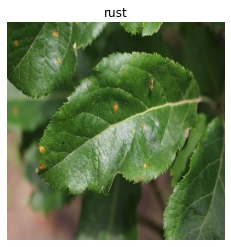

In [17]:
random_index = random.randrange(len(train_filenames))
filename = train_filenames[random_index]
img = convert_to_image(filename)
plt.title(label_by_filename[filename])
plt.imshow(img)
plt.axis(False);

## 2. One-hot encode the labels 
since the required submission format is probabilities

In [18]:
train_labels = tf.one_hot([label_to_int(label_by_filename[filename]) \
                           for filename in train_filenames], 4)
val_labels = tf.one_hot([label_to_int(label_by_filename[filename]) \
                         for filename in val_filenames], 4)

## 3. Create training and validation `tf.data.Dataset`

In [19]:
train_files_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
train_labels_ds =  tf.data.Dataset.from_tensor_slices(train_labels)
val_files_ds = tf.data.Dataset.from_tensor_slices(val_filenames)
val_labels_ds = tf.data.Dataset.from_tensor_slices(val_labels)

train_list_ds = tf.data.Dataset.zip((train_files_ds, train_labels_ds))
val_list_ds = tf.data.Dataset.zip((val_files_ds, val_labels_ds))

for f in train_list_ds.take(5):
    print(f[0].numpy(), f[1].numpy())

b'gs://kds-c21c9ca41b1c62ae12465f802200ef74ebe2a45995f976d3da5e693a/images/Train_0.jpg' [0. 0. 0. 1.]
b'gs://kds-c21c9ca41b1c62ae12465f802200ef74ebe2a45995f976d3da5e693a/images/Train_1.jpg' [0. 1. 0. 0.]
b'gs://kds-c21c9ca41b1c62ae12465f802200ef74ebe2a45995f976d3da5e693a/images/Train_2.jpg' [1. 0. 0. 0.]
b'gs://kds-c21c9ca41b1c62ae12465f802200ef74ebe2a45995f976d3da5e693a/images/Train_3.jpg' [0. 0. 1. 0.]
b'gs://kds-c21c9ca41b1c62ae12465f802200ef74ebe2a45995f976d3da5e693a/images/Train_4.jpg' [1. 0. 0. 0.]


## 4. Map the filenames Dataset to get images Dataset
## 5. Optimize Datasets for training

In [20]:
train_ds = prepare_for_training(train_list_ds)
val_ds = prepare_for_training(val_list_ds)

### Visualize some input images from the newly created dataset

In [21]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(8,4))
    for n in range(8):
        ax = plt.subplot(2,4,n+1)
        plt.imshow(image_batch[n])
        plt.title(one_hot_to_label(label_batch[n]))
        plt.axis("off")

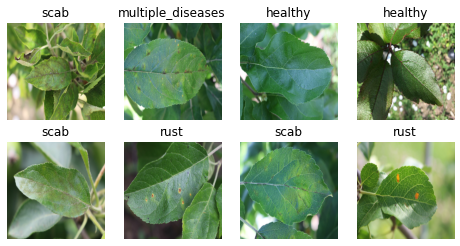

In [22]:
image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

This looks pretty reasonable, lets move on to defining and training the first model

# Set up the base simple CNN model

since we made our dataset infinite using `ds.repeat()` we need to set up  
`steps_per_epoch` - the number of steps for training  
`validaion_steps` - the number of steps for validation  

In [23]:
steps_per_epoch = math.ceil(len(train_filenames) / BATCH_SIZE)
validation_steps = math.ceil(len(val_filenames) / BATCH_SIZE)

### Define the model using 4 convolutions and compile 

Important thing to note here is a usage of `steps_per_execution` parameter of `model.compile()` 
> `steps_per_execution` instructs Keras to send multiple batches to the TPU at once. With this option, it is no longer necessary to push batch sizes to very high values to optimize TPU performance. As long as you use batch sizes of at least 8 per core (>=64 for a TPUv3-8) performance should be acceptable.

8 per core is exactly what we're using here.
Also we won't touch the default learning rate of Adam optimizer because we're not increasing the batch size drastically here  
Remember that 
> the rule of thumb calls for increasing the learning rate with the batch size. You can start with a proportional increase but additional tuning may be necessary to find the optimal learning rate schedule for a given model and accelerator.

In [24]:
def define_model(show_summary=False):
    model = tf.keras.models.Sequential([

        tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    
        # This is the first convolution
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(2, 2),

        # The second convolution
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),

        # The third convolution
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),

        # The fourth convolution
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),

        # Flatten the results to feed into a DNN
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.5),
        # 512 neuron hidden layer
        layers.Dense(512, activation='relu'),
        layers.Dense(4, activation='softmax')
    ])

    if show_summary:
        model.summary()
        
    model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'],
              steps_per_execution=32)
    
    return model

### Instantiate the model in the scope of the strategy. This creates the model on the TPU

In [25]:
with strategy.scope():
    model = define_model(show_summary=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 128)       1

### Fit and evaluate the model

Let's just examine the model's behaviour for 60 epochs for starters

In [26]:
history = model.fit(train_ds, 
                    steps_per_epoch=steps_per_epoch,
                    epochs=60, 
                    validation_data=val_ds,
                    validation_steps=validation_steps,
                    verbose=1)

Epoch 1/60
22/22 [==============================] - 24s 1s/step - loss: 1.2889 - accuracy: 0.3047 - val_loss: 1.2372 - val_accuracy: 0.3438
Epoch 2/60
22/22 [==============================] - 1s 43ms/step - loss: 1.2498 - accuracy: 0.3210 - val_loss: 1.2383 - val_accuracy: 0.3613
Epoch 3/60
22/22 [==============================] - 1s 46ms/step - loss: 1.2446 - accuracy: 0.3523 - val_loss: 1.2422 - val_accuracy: 0.3477
Epoch 4/60
22/22 [==============================] - 1s 40ms/step - loss: 1.2355 - accuracy: 0.3168 - val_loss: 1.2225 - val_accuracy: 0.3418
Epoch 5/60
22/22 [==============================] - 1s 41ms/step - loss: 1.2322 - accuracy: 0.3757 - val_loss: 1.2154 - val_accuracy: 0.3926
Epoch 6/60
22/22 [==============================] - 1s 39ms/step - loss: 1.2197 - accuracy: 0.3750 - val_loss: 1.2239 - val_accuracy: 0.4043
Epoch 7/60
22/22 [==============================] - 1s 38ms/step - loss: 1.1937 - accuracy: 0.4283 - val_loss: 1.2177 - val_accuracy: 0.3965
Epoch 8/60
22/

In [27]:
model.evaluate(val_ds, steps=validation_steps)

8/8 [==============================] - 1s 65ms/step - loss: 0.5882 - accuracy: 0.7969


[0.5881667137145996, 0.796875]

### Learning curves

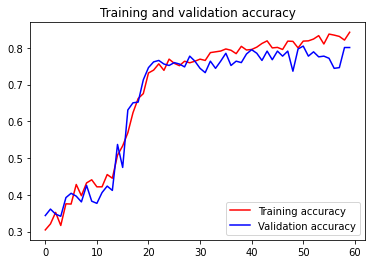

<Figure size 432x288 with 0 Axes>

In [28]:
plot_learning_curves(history)

## Read and prepare test images and make predictions

We don't want to shuffle or augment the test dataset, just split it into batches, prefetch and cache in memory to speed up the subsequent predictions

In [29]:
test_files_ds = tf.data.Dataset.from_tensor_slices(test_filenames)
test_ds = test_files_ds.map(convert_to_image, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE).cache()

Let's plot some images from the test dataset just for sanity check

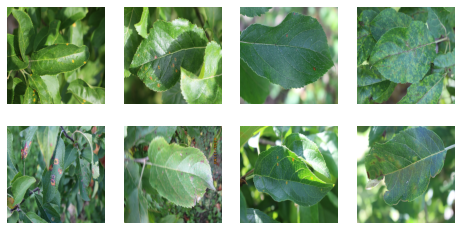

In [30]:
test_batch = next(iter(test_ds))
plt.figure(figsize=(8, 4))
for n in range(8):
    ax = plt.subplot(2,4,n+1)
    plt.imshow(test_batch[n])
    plt.axis("off")

Yet another helper function that maps the filenames to corresponding predictions and writes the obtained submission into a csv file

In [31]:
def generate_submission_from_predictions(predictions, submission_filename):
    imagenames = [filename[73:][:-4] for filename in test_filenames]
    prediction_df = pd.DataFrame.from_dict(dict(zip(imagenames, predictions)), orient='index',
                           columns=categories).reset_index()
    submission = test_df.merge(prediction_df, left_on='image_id', right_on='index')
    submission.drop(columns=['index'], inplace = True)
    submission.to_csv(f'./{submission_filename}.csv', index=False)

prediction_steps = math.ceil(len(test_filenames) / BATCH_SIZE)

In [32]:
predictions = model.predict(test_ds,steps = prediction_steps)
generate_submission_from_predictions(predictions, 'first_CNN')

# Ways to imporve

Even though the training speed is extremely impressive, prediction score for this model certainly can be improved.  
Also, from the training curves plot we can see that the model training score is getting farther from the validation score with every epoch.  
Let's see how we can improve the model

* Add data augmentation
* Use early stopping
* Use Transfer learning

Since our model trains so fast we can try it all one by one

## The same Model with Data Augmentation and Early Stopping

There are two ways of applying data augmentation (and preprocessing in general) with TensorFlow:
1. Add data augmentation layers into the model
1. Include data augmentation to the dataset preparation pipeline

> **Important note:**
>
> When running on **GPU** you'd want to use the **first option** to benefit from GPU acceleration.  
> When running on **TPU** you'd have to use the **second option** because data augmentation layers (except for `Normalization` and `Rescaling`) are not supported

If you try to `.fit()` a model that includes data augmentation layers on TPU you'll get a `TPU compilation failed` message with an error that looks something like this:


```
NotFoundError: 9 root error(s) found.
  (0) Not found: {{function_node __inference_train_function_183323}} No proto found for key <<NO PROGRAM AS COMPILATION FAILED>>
	 [[{{node TPUVariableReshard/reshard/_5957770828868222171/_22}}]]
  (1) Invalid argument: {{function_node __inference_train_function_183323}} Compilation failure: Detected unsupported operations when trying to compile graph while/cluster_while_body_181553_10451082903516086736[] on XLA_TPU_JIT: ImageProjectiveTransformV3 (No registered 'ImageProjectiveTransformV3' OpKernel for XLA_TPU_JIT devices compatible with node {{node while/body/_1/while/sequential_28/sequential_27/random_rotation_8/transform/ImageProjectiveTransformV3}}){{node while/body/_1/while/sequential_28/sequential_27/random_rotation_8/transform/ImageProjectiveTransformV3}}One approach is to outside compile the unsupported ops to run on CPUs by enabling soft placement `tf.config.set_soft_device_placement(True)`. This has a potential performance penalty.
	TPU compilation failed 
    etc....
```  
see more on this in [Tensorflow preprocessing guide](https://www.tensorflow.org/guide/keras/preprocessing_layers#preprocessing_data_before_the_model_or_inside_the_model)  

I have to say that I tried to use the recommended `tf.config.set_soft_device_placement(True)` with *no effect* whatsoever.

So, that's what we'll do, provide a data augmentation function to the `tf.data` pipeline

> **Another important note**:  
You should remove data augmentation layers that change weight or height of the output tensor (e.g. `RandomWidth`, `RandomHeight`)

Otherwise you'll get `NotFoundError` with `TPU compilation failed` message with an error that looks something like this:
```
  (6) Invalid argument: {{function_node __inference_train_function_248407}} Compilation failure: Dynamic Spatial Convolution is not supported: lhs shape is f32[<=8,<=274,<=286,3] 
	 [[{{node conv2d/Conv2D}}]]
	TPU compilation failed
	 [[tpu_compile_succeeded_assert/_3495234026254819081/_5]]
	 [[TPUVariableReshard/default_shard_state/_4480269216609879393/_8/_123]]
  (7) Not found: {{function_node __inference_train_function_248407}} No proto found for key <<NO PROGRAM AS COMPILATION FAILED>>
	 [[{{node TPUVariableReshard/reshard/_11705470937593059017/_16}}]]
  (8) Invalid argument: {{function_node __inference_train_function_248407}} Compilation failure: Dynamic Spatial Convolution is not supported: lhs shape is f32[<=8,<=274,<=286,3] 
	 [[{{node conv2d/Conv2D}}]]
	TPU compilation failed
	 [[tpu_compile_succeeded_assert/_3495234026254819081/_5]]
```

Remember that **only training dataset needs to be augmented**,  it doesn't make sense to augment validation dataset

In [33]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal'),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
    layers.experimental.preprocessing.RandomContrast(factor=0.2),
])

def data_augment(img, label):
    return data_augmentation(img), label

train_ds = prepare_for_training(train_list_ds, data_augment_fn=data_augment)

Also, let's instantiate and Early stopping callback not to have to decide on the number of epochs.  
By default `EarlyStopping` callback is monitoring validation loss and that works for us

In [34]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20,
                                                     restore_best_weights=True)


In [35]:
# tf.config.set_soft_device_placement(True)

with strategy.scope():
    model = define_model()
    
history = model.fit(train_ds, 
                    steps_per_epoch=steps_per_epoch,
                    epochs=500, 
                    validation_data=val_ds,
                    validation_steps=validation_steps,
                    verbose=1,
                    callbacks=[early_stopping_cb])

Epoch 1/500
22/22 [==============================] - 37s 2s/step - loss: 1.2850 - accuracy: 0.3189 - val_loss: 1.2408 - val_accuracy: 0.3477
Epoch 2/500
22/22 [==============================] - 1s 42ms/step - loss: 1.2577 - accuracy: 0.3381 - val_loss: 1.2393 - val_accuracy: 0.3340
Epoch 3/500
22/22 [==============================] - 1s 43ms/step - loss: 1.2533 - accuracy: 0.3246 - val_loss: 1.2383 - val_accuracy: 0.3496
Epoch 4/500
22/22 [==============================] - 1s 42ms/step - loss: 1.2529 - accuracy: 0.3359 - val_loss: 1.2284 - val_accuracy: 0.3809
Epoch 5/500
22/22 [==============================] - 1s 45ms/step - loss: 1.2352 - accuracy: 0.3558 - val_loss: 1.2416 - val_accuracy: 0.3398
Epoch 6/500
22/22 [==============================] - 1s 44ms/step - loss: 1.2514 - accuracy: 0.3324 - val_loss: 1.2167 - val_accuracy: 0.3574
Epoch 7/500
22/22 [==============================] - 1s 43ms/step - loss: 1.2404 - accuracy: 0.3295 - val_loss: 1.2360 - val_accuracy: 0.2734
Epoch 8

In [36]:
model.evaluate(val_ds, steps=validation_steps)

8/8 [==============================] - 1s 83ms/step - loss: 0.2620 - accuracy: 0.9336


[0.26201575994491577, 0.93359375]

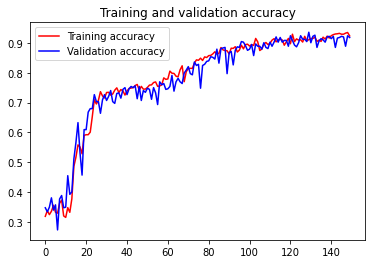

<Figure size 432x288 with 0 Axes>

In [37]:
plot_learning_curves(history);

We see that validation accuracy follows training accuracy much closer.  
It also takes more time to reach certain accuracy with data augmentation but hopefully will result in better model generalization  
Let's now make predictions and create a submission

In [38]:
predictions = model.predict(test_ds,steps = prediction_steps)
generate_submission_from_predictions(predictions, 'simpleCNN_with_data_aug')

# Transfer learning
## Feature extraction layer

We'll use EfficientNet V2 feature vectors [available on TensorFlow Hub](https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b0/feature_vector/2) as layers
To be precise it's
> Feature vectors of images with EfficientNet V2 with input size 224x224, trained on imagenet-21k (Full ImageNet, Fall 2011 release).



As it tends to happen, to be able to use the pretrained model on TPU, we need to make some adjustments.  
By default tfhub downloads compressed model and caches it to the local file system where TPU doesn't have access to.  
Recently the possibility to directly read uncompressed models from GCS was added  
To enable this behaviour we need to set 

`os.environ["TFHUB_MODEL_LOAD_FORMAT"] = "UNCOMPRESSED"`

In [39]:
os.environ["TFHUB_MODEL_LOAD_FORMAT"] = "UNCOMPRESSED"

efficientnet_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b0/classification/2"


Function that creates a model with feature extraction layer from TensorFlow Hub url

In [40]:
def create_feature_vectors_model(model_url):
    feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the pre-trained weights
                                           name='feature_extraction_layer')

    model = tf.keras.Sequential([
        feature_extractor_layer, # use the feature extraction layer as the base
        layers.Dropout(0.5), # add some regularization
        layers.Dense(len(categories), 
                     activation='softmax', 
                     name='output_layer') # create our own output layer 
      ])
    model.build([None, IMG_SIZE, IMG_SIZE, 3])
    
    model.summary()
    
    model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'],
              steps_per_execution=32) 
    
    return model

In [41]:
with strategy.scope():
    model = create_feature_vectors_model(efficientnet_url)

2022-10-27 06:00:09.170250: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-10-27 06:00:09.200142: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-10-27 06:00:09.244567: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-10-27 06:00:09.283565: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-10-27 06:00:09.320537: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 1000)              7200312   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1000)              0         
_________________________________________________________________
output_layer (Dense)         (None, 4)                 4004      
Total params: 7,204,316
Trainable params: 4,004
Non-trainable params: 7,200,312
_________________________________________________________________


In [42]:
history = model.fit(train_ds, 
                    steps_per_epoch=steps_per_epoch,
                    epochs=500, 
                    validation_data=val_ds,
                    validation_steps=validation_steps,
                    verbose=1,
                    callbacks=[early_stopping_cb])

Epoch 1/500
22/22 [==============================] - 26s 1s/step - loss: 2.0417 - accuracy: 0.4141 - val_loss: 0.6684 - val_accuracy: 0.7812
Epoch 2/500
22/22 [==============================] - 1s 41ms/step - loss: 1.0984 - accuracy: 0.6364 - val_loss: 0.5310 - val_accuracy: 0.8242
Epoch 3/500
22/22 [==============================] - 1s 40ms/step - loss: 0.8506 - accuracy: 0.7038 - val_loss: 0.4481 - val_accuracy: 0.8633
Epoch 4/500
22/22 [==============================] - 1s 64ms/step - loss: 0.7833 - accuracy: 0.7401 - val_loss: 0.4191 - val_accuracy: 0.8652
Epoch 5/500
22/22 [==============================] - 1s 42ms/step - loss: 0.6847 - accuracy: 0.7756 - val_loss: 0.4175 - val_accuracy: 0.8730
Epoch 6/500
22/22 [==============================] - 1s 43ms/step - loss: 0.6151 - accuracy: 0.8018 - val_loss: 0.4214 - val_accuracy: 0.8750
Epoch 7/500
22/22 [==============================] - 1s 47ms/step - loss: 0.6173 - accuracy: 0.8033 - val_loss: 0.4183 - val_accuracy: 0.8789
Epoch 8

In [43]:
model.evaluate(val_ds, steps=validation_steps)

8/8 [==============================] - 1s 90ms/step - loss: 0.3279 - accuracy: 0.8926


[0.32787925004959106, 0.892578125]

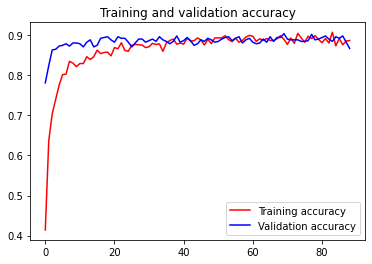

<Figure size 432x288 with 0 Axes>

In [44]:
plot_learning_curves(history);

In [45]:
predictions = model.predict(test_ds,steps = prediction_steps)
generate_submission_from_predictions(predictions, 'efficientnet_v2_feat_extraction')

Without the `Dropout` layer training set starts overfitting almost right away. After adding a 0.5 Dropout between the feature extraction and softmax layer overfitting doesn't happen. Althouth the performance of the model is a bit worse than the previous one, it barely scratches 90% accuracy.
That's kind of expected becase we have very specific dataset that differs from the one that the EfficientNet was trained on.    

Next logical step would be to fine-tune the base model by unfreezing all the weights or only some top layer weights. For the latter one would use `tf.keras.applications` API. The only caveat is that here on Kaggle Tensorflow version that comes with TPU is 2.4.1. And the latest models (eg the Efficientnet v2 family that we've just used) are not available. Please see a list of architectures available in TensorFlow 2.4 [here](https://www.tensorflow.org/versions/r2.4/api_docs/python/tf/keras/applications)

## What's next?
There are several different ways to potentially improve our predictions even more: 

* Implement transfer learning with fine-tuning
* use Test Time Augmentation (TTA), more information and examples [here](https://towardsdatascience.com/test-time-augmentation-tta-and-how-to-perform-it-with-keras-4ac19b67fb4d) actually one can think  of TTA as and implementation of Ensembling in a way.
* Ensembling = Combine the predictions from multiple trained models (there are lots of different ways to do it)

We won't go through these approaches here because in the end this notebook is dedicated to the topic of TPU usage.  

# The main points of this notebook are:
* **Using TPU is a real game-changer.** 
    TPUs incease the speed of training significantly. In appoximately 20 minutes we trained 3 big models
* **To be able to use TPUs you'll need to adapt your code and data pipelines**:
    * TPU read data exclusively from GCS - you'll need to adjust your data pipelines one way or the other
    * The use of `tf.data.Dataset` API is required as input for `model.fit()`
    * The model must be defined within the `TPUStrategy` scope
    * Models from TensorFlow Hub need to be read uncompressed
    * Data augmentation should be done outside the main model
    * Data augmentation layers that change the width and height of the input (e.g. `RandomWidth`, `RandomHeight`) shouldn't be used
    * etc.
* **To optimize the usage of TPU you need to**:
    * Adjust the Batch size (and potentially the learning rate)
    * Make sure your feature dimension sizes are a multiple of 8 or 128 (depends on the chosen batch size)
    * Use caching, prefetching and other optimizations to maximize TPU load
    * Use `steps_per_execution` parameter when compiling your model
    * Organize your data on GCS a certain way
    * etc.

### Links

* https://www.kaggle.com/docs/tpu
* https://www.kaggle.com/code/mgornergoogle/five-flowers-with-keras-and-xception-on-tpu/notebook
* https://www.kaggle.com/code/kathirolikabilan/tensorflow-pneumonia-classification-on-x-rays
* https://en.wikipedia.org/wiki/Tensor_Processing_Unit
* https://learntensorflow.io/ (mainly [this](https://dev.mrdbourke.com/tensorflow-deep-learning/06_transfer_learning_in_tensorflow_part_3_scaling_up/) and [this](https://dev.mrdbourke.com/tensorflow-deep-learning/04_transfer_learning_in_tensorflow_part_1_feature_extraction/) article)
* https://www.tensorflow.org/guide/keras/preprocessing_layers
* https://towardsdatascience.com/test-time-augmentation-tta-and-how-to-perform-it-with-keras-4ac19b67fb4d
* https://codelabs.developers.google.com/codelabs/keras-flowers-tpu
* https://cloud.google.com/tpu/docs/performance-guide
* https://github.com/tensorflow/hub/issues/604
* https://www.tensorflow.org/guide/data_performance
* https://www.tensorflow.org/guide/keras/preprocessing_layers#preprocessing_data_before_the_model_or_inside_the_model
* https://towardsdatascience.com/test-time-augmentation-tta-and-how-to-perform-it-with-keras-4ac19b67fb4d